# 🚀 MPC с Transformer-моделью динамики для Boeing 747

Этот пример демонстрирует использование **Transformer-архитектуры** для моделирования динамики самолета Boeing 747 в системе Model Predictive Control (MPC).

## 📋 Обзор

- **Модель**: Boeing 747 (продольная динамика)
- **Архитектура**: Transformer для предсказания следующего состояния
- **Размерность состояния**: 4 (скорость, угол атаки, угловая скорость тангажа, угол тангажа)
- **Управление**: 1 (отклонение руля высоты)
- **Данные**: 300,000 образцов с различными сигналами управления

## 🎯 Цель

Обучить Transformer-модель для точного предсказания динамики самолета и использовать её в MPC контроллере.

## 📚 Импорт библиотек и инициализация модели

Загружаем необходимые библиотеки и создаем Transformer-модель для изучения динамики системы.

In [15]:
# Импорт основных библиотек
from tensoraerospace.agent.mpc.transformers import TransformerDynamicsModel
from tensoraerospace.agent.mpc.dynamics import DynamicsNN
import torch
from tqdm import tqdm
from tensoraerospace.signals.standart import unit_step
from tensoraerospace.utils import generate_time_period, convert_tp_to_sec_tp
import numpy as np
import gymnasium as gym

# 🔧 Параметры модели
state_dim = 4      # Размерность вектора состояния (v, α, q, θ)
control_dim = 1    # Размерность вектора управления (δe)
input_dim = state_dim + control_dim  # Общая размерность входа
output_dim = state_dim               # Размерность выхода

print(f'🎯 Создание Transformer-модели динамики...')
print(f'   📊 Размерность входа: {input_dim}')
print(f'   📈 Размерность выхода: {output_dim}')

# 🧠 Создание Transformer-модели
nn_transformers = TransformerDynamicsModel(input_dim, output_dim)
dynamics_nn = DynamicsNN(nn_transformers)

print('✅ Модель успешно создана!')

## 🛩️ Создание симуляционной среды Boeing 747

Настраиваем параметры симуляции и создаем среду для модели Boeing 747 с заданным опорным сигналом.

In [16]:
# ⏱️ Параметры времени
dt = 0.01  # Шаг дискретизации (10 мс)
tp = generate_time_period(tn=20, dt=dt)  # Временной период 20 секунд
tps = convert_tp_to_sec_tp(tp, dt=dt)
number_time_steps = len(tp)  # Количество временных шагов

print(f'⏱️ Параметры симуляции:')
print(f'   🕐 Время симуляции: {tp[-1]:.1f} сек')
print(f'   📊 Шаг дискретизации: {dt} сек')
print(f'   🔢 Количество шагов: {number_time_steps}')

# 📈 Создание опорного сигнала (ступенчатый сигнал 5°)
reference_signals = np.reshape(
    unit_step(degree=5, tp=tp, time_step=10, output_rad=True), 
    [1, -1]
)

print(f'📈 Опорный сигнал: ступенчатый сигнал 5° на 10-й секунде')

# 🛩️ Создание среды Boeing 747
print('🛩️ Инициализация среды Boeing 747...')
env = gym.make('LinearLongitudinalB747-v0',
               number_time_steps=number_time_steps, 
               initial_state=[[0],[0],[0],[0]],  # Начальное состояние [v, α, q, θ]
               reference_signal=reference_signals)

state, info = env.reset()
print('✅ Среда успешно создана и инициализирована!')

/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:168: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.deprecation(
/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/util

## ⚙️ Настройка параметров модели

Извлекаем матрицы состояния A и B из модели Boeing 747 и определяем диапазоны для генерации обучающих данных.

In [18]:
# 📊 Диапазоны состояний для генерации данных
# [скорость, угол_атаки, угловая_скорость_тангажа, угол_тангажа]
state_ranges = [
    (-10.0, 10.0),   # Δv (м/с) - отклонение скорости
    (-4.5, 4.5),     # Δα (рад) - отклонение угла атаки
    (-2.3, 2.3),     # Δq (рад/с) - отклонение угловой скорости тангажа
    (-15.0, 15.0)    # Δθ (рад) - отклонение угла тангажа
]

print('📊 Диапазоны состояний:')
state_names = ['Скорость (м/с)', 'Угол атаки (рад)', 'Угл. скорость (рад/с)', 'Угол тангажа (рад)']
for i, (name, (min_val, max_val)) in enumerate(zip(state_names, state_ranges)):
    print(f'   {i+1}. {name}: [{min_val}, {max_val}]')

# 🔢 Извлечение матриц линейной модели
A = torch.tensor(env.unwrapped.model.A, dtype=torch.float32)
B = torch.tensor(env.unwrapped.model.B, dtype=torch.float32)

print(f'
🔢 Матрицы модели:')
print(f'   📐 Матрица A: {A.shape}')
print(f'   📐 Матрица B: {B.shape}')

# 🎛️ Диапазон управления (по умолчанию: -25° до +25°)
print('🎛️ Диапазон управления: [-25°, +25°] (руль высоты)')
print('✅ Параметры модели настроены!')

## 📊 Генерация обучающих данных

Создаем большой набор данных с различными типами управляющих сигналов для обучения Transformer-модели.

In [19]:
# 🎯 Параметры генерации данных
num_samples = 300_000

# 📈 Типы управляющих сигналов для разнообразия данных
control_signals = [
    "sine",              # Синусоидальные сигналы
    "step",              # Ступенчатые сигналы
    "sine_09",           # Синус с амплитудой 0.9
    "sine_07",           # Синус с амплитудой 0.7
    "sine_05_low_freq",  # Низкочастотный синус
    "gaussian_noise",    # Гауссовский шум
    "linear_up",         # Линейно возрастающий
    "linear_down"        # Линейно убывающий
]

print(f'📊 Генерация обучающих данных...')
print(f'   🔢 Количество образцов: {num_samples:,}')
print(f'   📈 Типы сигналов: {len(control_signals)}')
for i, signal in enumerate(control_signals, 1):
    print(f'      {i}. {signal}')

print('⏳ Генерация данных... (это может занять некоторое время)')

# 🚀 Генерация данных
states, controls, next_states = dynamics_nn.generate_training_data(
    num_samples=num_samples, 
    state_dim=4, 
    control_dim=1,
    state_ranges=state_ranges, 
    control_ranges=None,  # Используем диапазон по умолчанию [-25, 25]
    control_signals=control_signals,
    A=A, 
    B=B
)

print(f'✅ Данные успешно сгенерированы!')
print(f'   📊 Форма состояний: {states.shape}')
print(f'   🎛️ Форма управлений: {controls.shape}')
print(f'   📈 Форма следующих состояний: {next_states.shape}')

## 🧠 Обучение Transformer-модели

Запускаем процесс обучения нейронной сети с архитектурой Transformer для изучения динамики Boeing 747.

**Параметры обучения:**
- Эпохи: 400
- Размер батча: 1024
- Вывод прогресса каждые 20 эпох

In [5]:
# 🎯 Параметры обучения
epochs = 400
batch_size = 1024
verbose_epoch = 20

print(f'🧠 Начинаем обучение Transformer-модели...')
print(f'   📊 Эпохи: {epochs}')
print(f'   📦 Размер батча: {batch_size}')
print(f'   📈 Вывод прогресса каждые {verbose_epoch} эпох')
print(f'   🔥 Архитектура: Transformer')
print('
' + '='*50)

# 🚀 Запуск обучения
dynamics_nn.train_and_validate(
    torch.tensor(states, dtype=torch.float32),
    torch.tensor(controls, dtype=torch.float32),
    torch.tensor(next_states, dtype=torch.float32), 
    epochs=epochs, 
    batch_size=batch_size, 
    verbose_epoch=verbose_epoch
)

print('
' + '='*50)
print('🎉 Обучение завершено!')

/var/folders/kq/3y1y4twn3ls4zqd3ct3bbjz00000gp/T/ipykernel_35844/222292088.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(states, dtype=torch.float32),
/var/folders/kq/3y1y4twn3ls4zqd3ct3bbjz00000gp/T/ipykernel_35844/222292088.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(controls, dtype=torch.float32),
/var/folders/kq/3y1y4twn3ls4zqd3ct3bbjz00000gp/T/ipykernel_35844/222292088.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(next_states, dtype=torch.float32), epochs=400, batch_size=1024

Подготовка данных
Загрузка  данных
Начала обучения 


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 1/400 [00:05<36:12,  5.45s/it]

Epoch 1, Train Loss: 0.093298, Val Loss: 0.006955


  5%|▌         | 21/400 [01:52<33:53,  5.36s/it]

Epoch 21, Train Loss: 0.000505, Val Loss: 0.000477


 10%|█         | 41/400 [03:39<32:22,  5.41s/it]

Epoch 41, Train Loss: 0.000152, Val Loss: 0.000082


 15%|█▌        | 61/400 [05:27<30:18,  5.36s/it]

Epoch 61, Train Loss: 0.000086, Val Loss: 0.000016


 20%|██        | 81/400 [07:15<29:26,  5.54s/it]

Epoch 81, Train Loss: 0.000036, Val Loss: 0.000064


 25%|██▌       | 101/400 [09:06<27:27,  5.51s/it]

Epoch 101, Train Loss: 0.000028, Val Loss: 0.000012


 30%|███       | 121/400 [10:54<24:59,  5.38s/it]

Epoch 121, Train Loss: 0.000021, Val Loss: 0.000012


 35%|███▌      | 141/400 [12:42<23:02,  5.34s/it]

Epoch 141, Train Loss: 0.000019, Val Loss: 0.000001


 40%|████      | 161/400 [14:30<21:02,  5.28s/it]

Epoch 161, Train Loss: 0.000015, Val Loss: 0.000024


 45%|████▌     | 181/400 [16:18<19:37,  5.38s/it]

Epoch 181, Train Loss: 0.000024, Val Loss: 0.000007


 50%|█████     | 201/400 [18:07<18:04,  5.45s/it]

Epoch 201, Train Loss: 0.000020, Val Loss: 0.000033


 55%|█████▌    | 221/400 [19:52<15:26,  5.18s/it]

Epoch 221, Train Loss: 0.000013, Val Loss: 0.000014


 60%|██████    | 241/400 [21:34<13:30,  5.10s/it]

Epoch 241, Train Loss: 0.000021, Val Loss: 0.000130


 65%|██████▌   | 261/400 [23:17<11:49,  5.10s/it]

Epoch 261, Train Loss: 0.000024, Val Loss: 0.000003


 70%|███████   | 281/400 [25:04<10:29,  5.29s/it]

Epoch 281, Train Loss: 0.000011, Val Loss: 0.000002


 75%|███████▌  | 301/400 [26:49<08:45,  5.31s/it]

Epoch 301, Train Loss: 0.000496, Val Loss: 0.000005


 80%|████████  | 321/400 [28:37<07:16,  5.52s/it]

Epoch 321, Train Loss: 0.000013, Val Loss: 0.000015


 85%|████████▌ | 341/400 [30:25<05:15,  5.35s/it]

Epoch 341, Train Loss: 0.000007, Val Loss: 0.000004


 90%|█████████ | 361/400 [32:13<03:34,  5.50s/it]

Epoch 361, Train Loss: 0.000706, Val Loss: 0.000061


 95%|█████████▌| 381/400 [34:03<01:51,  5.85s/it]

Epoch 381, Train Loss: 0.000008, Val Loss: 0.000003


100%|██████████| 400/400 [35:44<00:00,  5.36s/it]


## 🎮 Тестирование MPC контроллера с Transformer-моделью

Теперь используем обученную Transformer-модель в MPC контроллере для управления Boeing 747.

**Параметры MPC:**
- Горизонт предсказания: 40 шагов
- Веса Q и R для оптимизации
- Ограничения на управление

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:08<00:00,  4.93it/s]


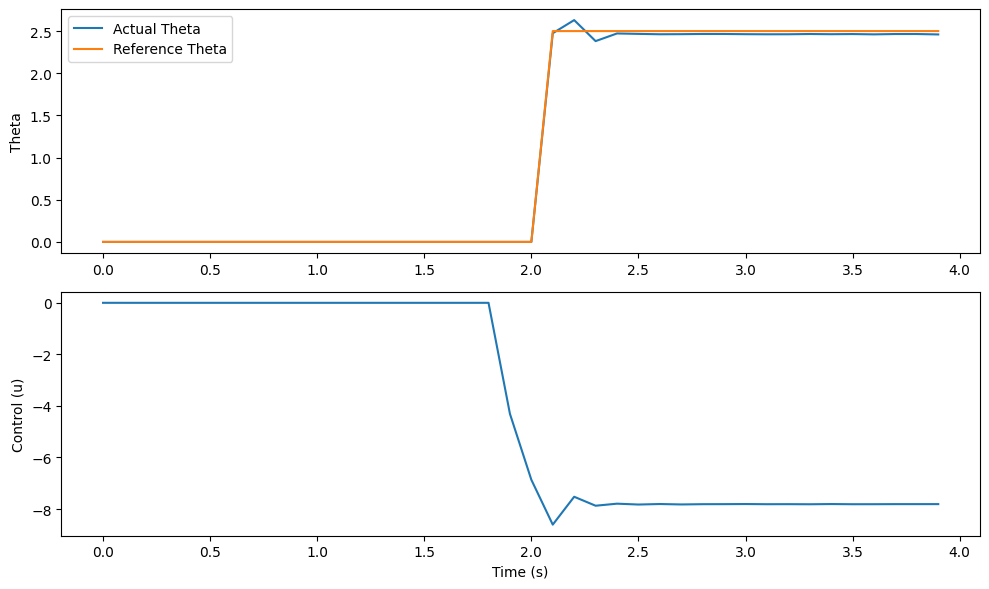

In [ ]:
# 📚 Импорт дополнительных библиотек
import numpy as np
import torch
import matplotlib.pyplot as plt
from tensoraerospace.agent.mpc.base import AircraftMPC

# 🎮 Параметры MPC контроллера
horizon = 2          # Горизонт предсказания
dt_mpc = 0.1         # Шаг времени для MPC
iterations = 50      # Количество итераций оптимизации
learning_rate = 10e-6  # Скорость обучения
increment = 1e-4     # Инкремент для градиента

print(f'🎮 Инициализация MPC контроллера...')
print(f'   🔭 Горизонт предсказания: {horizon}')
print(f'   ⏱️ Шаг времени: {dt_mpc} сек')
print(f'   🔄 Итераций оптимизации: {iterations}')

# 🚀 Создание MPC контроллера с обученной Transformer-моделью
mpc = AircraftMPC(
    dynamics_nn.model, 
    horizon=horizon, 
    dt=dt_mpc, 
    iterations=iterations,
    learning_rate=learning_rate, 
    increment=increment
)

# ⏱️ Параметры симуляции
simulation_time = 4  # Время симуляции (сек)
dt_sim = 0.1         # Шаг симуляции
steps = int(simulation_time / dt_sim)

print(f'⏱️ Параметры симуляции:')
print(f'   🕐 Время симуляции: {simulation_time} сек')
print(f'   📊 Шаг симуляции: {dt_sim} сек')
print(f'   🔢 Количество шагов: {steps}')

# 🎯 Начальное состояние [v, α, q, θ]
x0 = np.array([0, 0, 0, 0])  # Все состояния начинаются с нуля
states = [x0]
controls = []

print(f'🎯 Начальное состояние: {x0}')

# 📈 Генерация опорной траектории (ступенчатый сигнал)
time = np.arange(steps + horizon + 1) * dt_sim
theta_ref = unit_step(degree=2.5, tp=time, time_step=0.02, output_rad=False)

print(f'📈 Опорная траектория: ступенчатый сигнал 2.5° на 0.02 сек')

# 🔢 Матрицы системы для симуляции (Boeing 747)
A_sim = torch.tensor([
    [-0.0212, 0.0466,    0,   0.1153],
    [-0.2229, -0.5839, 0.9404, 0],
    [0.0150,  -0.5031, -0.5015, 0],
    [0, 0, 1, 0],
], dtype=torch.float32)

B_sim = torch.tensor([
    [0],
    [-0.0340],
    [-0.5746],
    [0]
], dtype=torch.float32)

# 📊 Инициализация массивов для хранения результатов
model_states = [torch.tensor([0, 0, 0, 0], dtype=torch.float32)]

print('🚀 Запуск симуляции MPC...')
print('='*40)

# 🔄 Основной цикл управления
for i in tqdm(range(steps), desc='🎮 MPC Симуляция'):
    # Получаем текущий опорный сигнал
    current_ref = theta_ref[i:i + horizon + 1]
    
    # Оптимизируем управление с помощью MPC
    u_opt, predicted_states = mpc.optimize_control(states[-1], current_ref)
    
    # Симулируем следующее состояние системы
    next_states = A_sim @ model_states[i] + B_sim @ torch.tensor(u_opt, dtype=torch.float32)

    # Сохраняем результаты
    controls.append(u_opt)
    model_states.append(next_states)
    # next_state = predicted_states[0]
    states.append(next_states)

# Визуализация результатов
time_array = np.arange(0, simulation_time, dt)
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(time_array, [s[3] for s in states[:-1]], label="Actual Theta")
plt.plot(time_array, theta_ref[:steps], label="Reference Theta")
plt.ylabel("Theta")
# plt.ylim([0, 1.2])
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time_array, controls)
plt.xlabel("Time (s)")
plt.ylabel("Control (u)")

plt.tight_layout()
plt.show()

In [12]:
from tensoraerospace.benchmark import ControlBenchmark
bench = ControlBenchmark()
res = bench.becnchmarking_one_step(theta_ref[:-3], np.array([float(s[3]) for s in states[:-1]]), 1.9, dt)


In [13]:
print("Статическая ошибка: ", res['static_error'])
print("Время переходного процесса: ", res['settling_time'], "сек")
print("Степень затухания: ", res['damping_degree'])
print("Перерегулирование: ", res['overshoot'])


Статическая ошибка:  0.03743922710418701
Время переходного процесса:  0.2 сек
Степень затухания:  0.012593524089427021
Перерегулирование:  5.2121734619140625


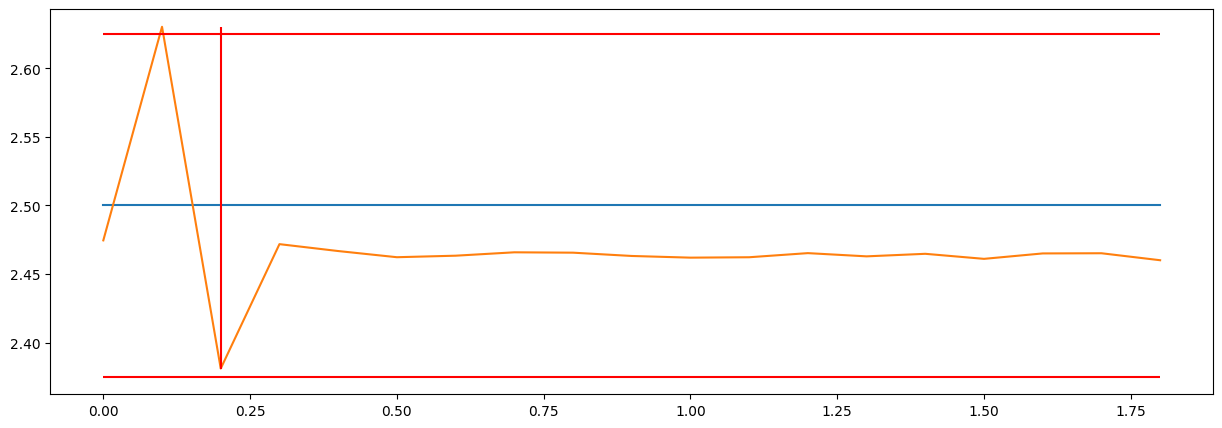

In [14]:
bench.plot(theta_ref[:-3], np.array([float(s[3]) for s in states[:-1]]), 0.9, dt, time, figsize=(15,5))
